In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_vit = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_vit)
testset_vit = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_vit)

trainloader_vit = torch.utils.data.DataLoader(trainset_vit, batch_size=64, shuffle=True)
testloader_vit = torch.utils.data.DataLoader(testset_vit, batch_size=64, shuffle=False)


In [ ]:

import torch
import torch.nn as nn
import math
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size
        self.proj = nn.Linear(self.patch_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, 4, 4).unfold(3, 4, 4)  # (B, C, num_patches_h, num_patches_w, patch_h, patch_w)
        x = x.contiguous().view(B, C, -1, 4, 4)
        x = x.permute(0, 2, 1, 3, 4).reshape(B, -1, self.patch_dim)
        return self.proj(x)  # (B, num_patches, embed_dim)
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # +1 for CLS

    def forward(self, x):
        # Get the required positional embeddings based on input sequence length
        pos_embed_sliced = self.pos_embed[:, :x.shape[1], :]
        return x + pos_embed_sliced # Apply sliced positional embeddings
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.fc(out)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_dim=512):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = PositionalEncoding(self.patch_embed.num_patches, embed_dim)

        self.transformer = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)
        x = self.pos_embed(x)

        x = self.transformer(x)
        x = self.norm(x[:, 0])  # Take CLS token
        return self.head(x)


In [ ]:
import time

def train_model(model, trainloader, testloader, epochs=20, lr=0.001, patience=5, use_scheduler=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    best_loss = float('inf')
    patience_counter = 0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / len(trainloader))

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc.append(100 * correct / total)
        test_loss.append(val_loss / len(testloader))

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc[-1]:.2f}% | Val Acc: {test_acc[-1]:.2f}% | Val Loss: {test_loss[-1]:.4f}")

        # Scheduler step
        if use_scheduler:
            scheduler.step(test_loss[-1])

        # Early Stopping Check
        if test_loss[-1] < best_loss:
            best_loss = test_loss[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds.")

    return train_acc, test_acc, train_loss, test_loss


In [ ]:
cnn_model = CNN()
cnn_train_acc, cnn_test_acc, cnn_train_loss, cnn_test_loss = train_model(
    cnn_model, trainloader, testloader, epochs=10, lr=0.001
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Acc: 41.39% | Val Acc: 58.54% | Val Loss: 1.1660
Epoch 2/10 | Train Acc: 54.44% | Val Acc: 63.02% | Val Loss: 1.0191
Epoch 3/10 | Train Acc: 59.12% | Val Acc: 67.46% | Val Loss: 0.9112
Epoch 4/10 | Train Acc: 62.76% | Val Acc: 68.17% | Val Loss: 0.8917
Epoch 5/10 | Train Acc: 65.03% | Val Acc: 72.39% | Val Loss: 0.7871
Epoch 6/10 | Train Acc: 66.96% | Val Acc: 74.06% | Val Loss: 0.7474
Epoch 7/10 | Train Acc: 68.60% | Val Acc: 74.59% | Val Loss: 0.7230
Epoch 8/10 | Train Acc: 69.85% | Val Acc: 75.60% | Val Loss: 0.7079
Epoch 9/10 | Train Acc: 70.73% | Val Acc: 77.16% | Val Loss: 0.6597
Epoch 10/10 | Train Acc: 72.17% | Val Acc: 77.44% | Val Loss: 0.6551

Training completed in 265.17 seconds.


In [ ]:
vit_scratch = ViT()
vit_scratch_train_acc, vit_scratch_test_acc, vit_scratch_train_loss, vit_scratch_test_loss = \
    train_model(vit_scratch, trainloader, testloader, epochs=10, lr=3e-4)


Epoch 1/10 | Train Acc: 34.12% | Val Acc: 44.89% | Val Loss: 1.5251
Epoch 2/10 | Train Acc: 45.34% | Val Acc: 51.16% | Val Loss: 1.3710
Epoch 3/10 | Train Acc: 49.40% | Val Acc: 54.34% | Val Loss: 1.2694
Epoch 4/10 | Train Acc: 52.70% | Val Acc: 56.16% | Val Loss: 1.2238
Epoch 5/10 | Train Acc: 54.99% | Val Acc: 57.91% | Val Loss: 1.1869
Epoch 6/10 | Train Acc: 57.69% | Val Acc: 60.41% | Val Loss: 1.1145
Epoch 7/10 | Train Acc: 59.49% | Val Acc: 60.88% | Val Loss: 1.0880
Epoch 8/10 | Train Acc: 61.12% | Val Acc: 62.31% | Val Loss: 1.0361
Epoch 9/10 | Train Acc: 62.50% | Val Acc: 63.43% | Val Loss: 1.0237
Epoch 10/10 | Train Acc: 64.09% | Val Acc: 64.34% | Val Loss: 0.9935

Training completed in 537.95 seconds.


In [ ]:
def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("🔍 Evaluating CNN Model:")
evaluate_model(cnn_model, testloader)

print("\n🔍 Evaluating ViT Model:")
evaluate_model(vit_scratch, testloader)


🔍 Evaluating CNN Model:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1000
           1       0.95      0.85      0.90      1000
           2       0.66      0.65      0.66      1000
           3       0.66      0.57      0.61      1000
           4       0.71      0.80      0.75      1000
           5       0.72      0.66      0.69      1000
           6       0.83      0.81      0.82      1000
           7       0.82      0.82      0.82      1000
           8       0.85      0.86      0.85      1000
           9       0.85      0.87      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Confusion Matrix:
 [[864   5  41   8  11   2   1   9  42  17]
 [ 25 851   1   1   0   2   1   1  35  83]
 [ 86   0 649  25  95  37  53  36  10   9]
 [ 27   3  73 569  62 146  55  31  21  13]
 [ 22   1  43  41 795  12 

In [ ]:
def plot_curves(train_acc, test_acc, train_loss, test_loss, title="CNN"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(test_acc, label="Test Acc")
    plt.title(f"{title} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.title(f"{title} Loss")
    plt.legend()
    plt.show()


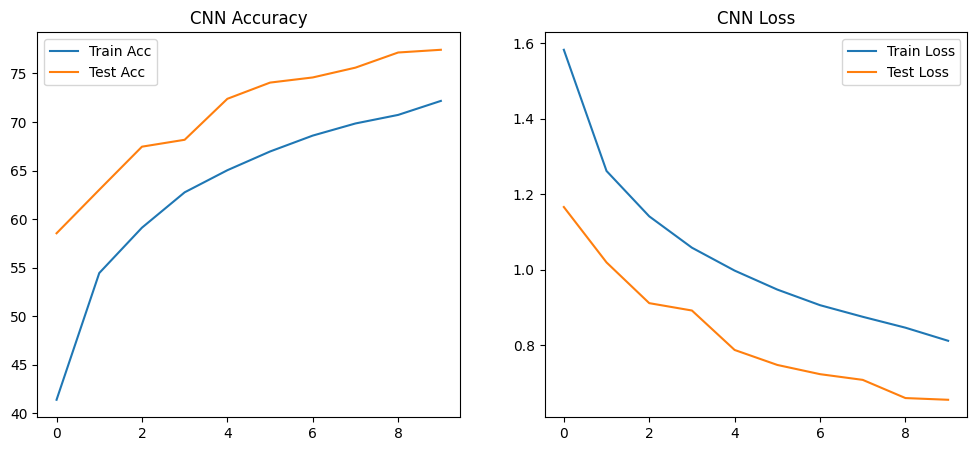

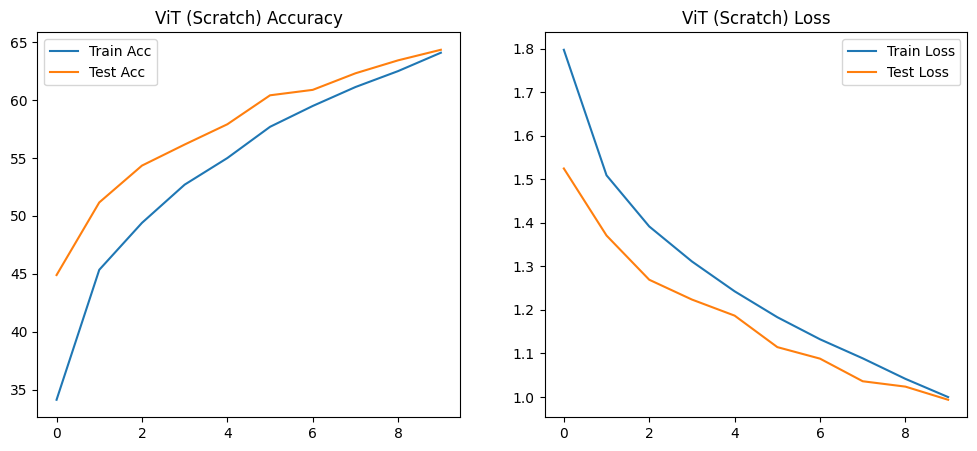

In [ ]:
plot_curves(cnn_train_acc, cnn_test_acc, cnn_train_loss, cnn_test_loss, title="CNN")
plot_curves(
    vit_scratch_train_acc,
    vit_scratch_test_acc,
    vit_scratch_train_loss,
    vit_scratch_test_loss,
    title="ViT (Scratch)"
)



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
print("📦 CNN Parameter Count:", count_parameters(cnn_model))
print("📦 ViT Parameter Count:", count_parameters(vit_scratch))


📦 CNN Parameter Count: 620810
📦 ViT Parameter Count: 3195146
